In [25]:
%load_ext autoreload
%autoreload 2

from ff_energy.structure import Structure
from ff_energy.job import Job
from ff_energy.plot import plot_energy_MSE
import pandas as pd

# s = Structure("/home/boittier/charmm/mix3/jobs/pdbs/mix0.pdb")

kwargs = {"m_nproc": 4, "m_memory": 480, "m_queue": "short", 
          "m_basis": "avdz", "m_method": "run,ks,pbe0",
          "chmpath": "/home/boittier/dev-release-dcm/build/cmake/charmm",
          "modules": "module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3",
          "c_files": ["pbe0_dz.mdcm"],
          "c_dcm_command": f"open unit 11 card read name pbe0_dz.mdcm \nDCM IUDCM 11 TSHIFT XYZ 15",
          }

JOBDIR = "d3d/mdcm_pbe0dz"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from pathlib import Path
import os
PDBPATH = Path("/home/boittier/charmm/test/dimer3d/")
pdbs = [_ for _ in os.listdir(PDBPATH) if _.endswith("pdb")]

In [27]:
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    # j.generate_molpro()
    j.generate_charmm()

In [28]:
# for x in *; do cd $x; cd charmm; sbatch *.slurm; cd ../..; done
# for x in *; do cd $x/monomers; for y in *.sh; do sbatch $y; done ; cd ../..; done

In [29]:
mp = "/home/boittier/homeb/d3d/pbe0dz/{}/monomers"

for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.generate_coloumb_interactions(monomers_path=Path(mp.format(ID)))
    j.generate_polarization(nch_per_monomer=(6, 6),
                           monomers_path=Path(mp.format(ID))
                           )

In [30]:
# for x in *; do cd $x/coloumb; for y in *.sh; do sbatch $y; done ; cd ../..; done
# for x in *; do cd $x/polarization; for y in *.slurm; do sbatch $y; done ; cd ../..; done

In [31]:
# p_data = j.gather_data()

In [52]:
structures = []
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    j.load_dcm()
    structures.append(j.structure)


In [76]:
i = 20
print(pdbs[i])
print(output[i]["charmm"]["ELEC"])
dcm = structures[i].dcm_charges
dcm_a = dcm[:6]
dcm_b = dcm[6:]


def Ecoloumb(q1,q2,r):
    """Calculate the coulombic energy between two charges,
    with atomic units and angstroms for distance"""
    coloumns_constant = 3.32063711e+2
    return coloumns_constant * q1*q2/r

E = 0
for ia, ca in enumerate(dcm_a):
    for ib, cb in enumerate(dcm_b):
        ca = np.array(ca)
        cb = np.array(cb)
        r = np.linalg.norm(ca[:3] - cb[:3])
        E += Ecoloumb(ca[3], cb[3], r)
        
print(E)
    



15-4.xyz.pdb
15-4   -0.06177
Name: ELEC, dtype: float64
-0.0614874013314719


In [32]:
mp = "/home/boittier/homeb/d3d/pbe0dz/{}/monomers"

output = []
for p in pdbs:
    s_path = PDBPATH / p
    s = Structure(s_path)
    s.set_2body()
    ID = p.split(".")[0]
    j = Job(ID, f"/home/boittier/homeb/{JOBDIR}/{ID}", s, kwargs=kwargs)
    o = j.gather_data(monomers_path=Path(mp.format(ID)))
    output.append(o)

In [33]:
o = j.gather_data()

In [34]:
o["polarization"].sum()

QMMM        -152.070288
KEY        17-1_117-1_2
NOFIELD     -152.070178
pol            -0.06903
dtype: object

In [35]:
#  generate molpro jobs and wait
#  generate charmm jobs and wait
#  generate orbkit jobs

In [36]:
chm_df = pd.concat([_["charmm"] for _ in output])

In [37]:
ctot = pd.concat([_["coloumb_total"] for _ in output])

In [38]:
_ = pd.concat([_["polarization"].sum() for _ in output])

In [39]:
pol_df = pd.concat([_["pol_total"] for _ in output])

In [40]:
pol_df

,POL,KEY
7-3,-0.807193,7-3
3-1,-7.050889,3-1
8-2,-0.560622,8-2
3-3,-7.004972,3-3
9-3,-0.357575,9-3
...,...,...
6-2,-1.364231,6-2
20-1,-0.044288,20-1
7-2,-0.851549,7-2
19-1,-0.050939,19-1


In [41]:
#  convert molpro csv
converters = {i: lambda x: float(x.strip().replace("D","E")) * 627.503 * 10**(-3) for i in range(3,10)}
converters[0] = lambda x: x
converters[1] = lambda x: float(x.strip().replace("D","E"))
converters[2] = lambda x: float(x.strip().replace("D","E"))

#  read molpro csv
df = pd.read_csv("/home/boittier/pcbach/dimer3d/sapt.csv", converters=converters)
#  strip whitespace in column names
df = df.rename(columns=lambda x: x.strip())

In [42]:
df["KEY"] = df["KEYS"].apply(lambda x: x.strip())
df

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1
...,...,...,...,...,...,...,...,...,...,...,...
107,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5
108,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5
109,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5
110,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5


In [43]:
pol_3d = pd.merge(df, pol_df, on="KEY")
pol_3d = pd.merge(pol_3d, ctot)
pol_3d = pd.merge(pol_3d, chm_df)
pol_3d

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY,POL,ECOL,TOTAL,ELEC,VDW
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1,-25.290578,-65.850672,56030.75158,-40.92751,11137.70216
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1,-12.299920,-61.354694,1462.25695,-23.12944,477.46500
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1,-7.050889,-36.208831,102.95921,-14.21051,55.36028
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1,-4.114389,-20.171970,16.56052,-9.28255,10.23080
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1,-2.385451,-11.571804,15.50393,-6.35957,2.08525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5,-0.112443,-0.842129,15.73112,-0.67369,-0.08670
76,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5,-0.052291,-0.434121,15.57741,-0.34913,-0.03643
77,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5,-0.027987,-0.247050,15.52504,-0.19772,-0.01640
78,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5,-0.007716,-0.074086,15.57107,-0.05817,-0.00283


(1.0, 8.0)

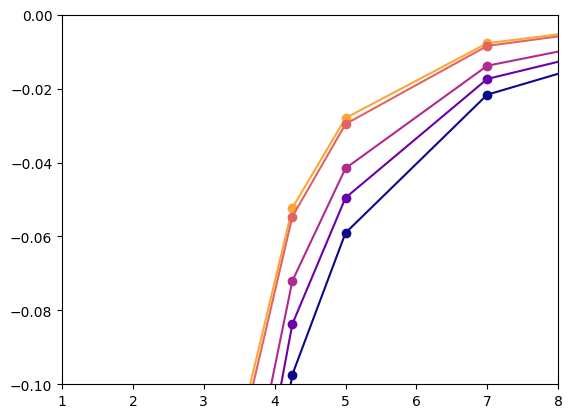

In [44]:
import matplotlib.pyplot as plt
import numpy as np

TS = list(set(df["TS"]))
TS.sort()
colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))

ax = plt.figure().add_subplot()

for i, ts in enumerate(TS):
    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["POL"], "-o",  c=colors[i])
    
plt.ylim(-.1,0)
# plt.yscale("log")
plt.axhline(0, c="k", linewidth=0.1)
plt.xlim(1,8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


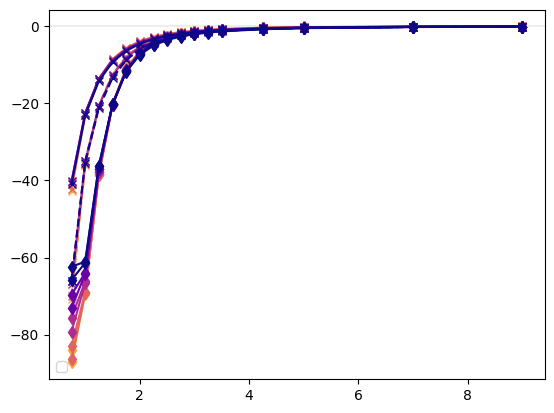

In [45]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.plasma_r(np.linspace(0, 1, len(TS)))
TS = list(set(df["TS"]))
TS.sort()

ax = plt.figure().add_subplot()

for i, ts in enumerate(TS):
    tmp = pol_3d[pol_3d["TS"] == ts]
    tmp = tmp[tmp["RS"] > 0]
    # ax.plot(tmp["RS"], tmp["ETOT"] - tmp["ELST"], "-o",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ECOL"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELST"], "-d",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"], "-x",  c=colors[i])
    ax.plot(tmp["RS"], tmp["ELEC"] + tmp["POL"], "--x",  c=colors[i])
    
plt.legend()
# plt.ylim(-10,0)
plt.axhline(0, c="k", linewidth=0.1)
# plt.xlim(1.5,3)

In [46]:
j.kwargs

{'m_nproc': 4,
 'm_memory': 480,
 'm_queue': 'short',
 'm_basis': 'avdz',
 'm_method': 'run,ks,pbe0',
 'chmpath': '/home/boittier/dev-release-dcm/build/cmake/charmm',
 'modules': 'module load cmake/cmake-3.23.0-gcc-11.2.0-openmpi-4.1.3',
 'c_files': ['pbe0_dz.mdcm'],
 'c_dcm_command': 'open unit 11 card read name pbe0_dz.mdcm \nDCM IUDCM 11 TSHIFT XYZ 15'}

In [47]:
pol_3d["ELECpol"] = pol_3d["ELEC"] + pol_3d["POL"]

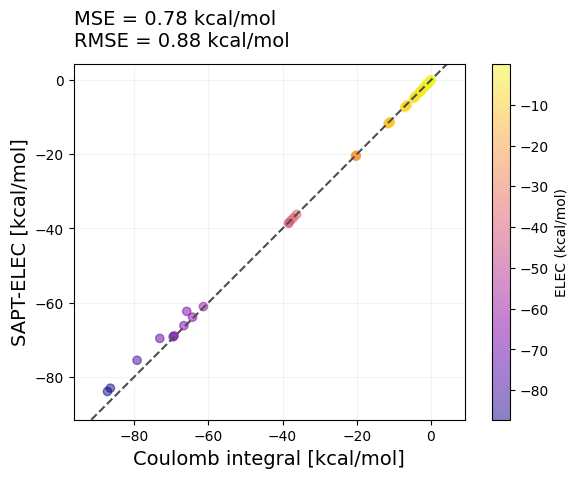

In [48]:
plot_energy_MSE(pol_3d, "ECOL", "ELST", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="SAPT-ELEC [kcal/mol]")

plt.savefig("sapt_vs_ci.pdf", bbox_inches="tight")

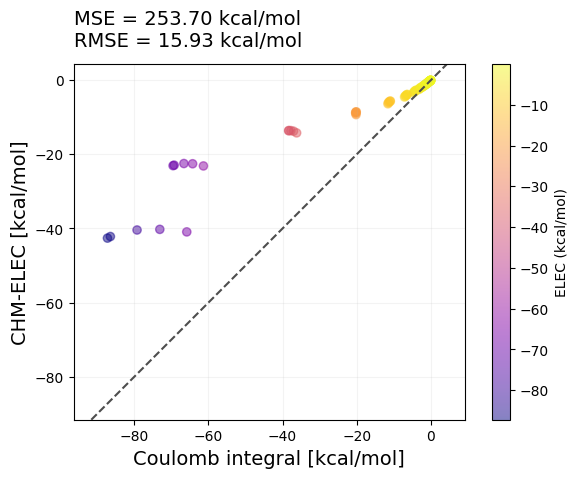

In [49]:
plot_energy_MSE(pol_3d, "ECOL", "ELEC", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC [kcal/mol]")
plt.savefig("chm_vs_ci.pdf", bbox_inches="tight")

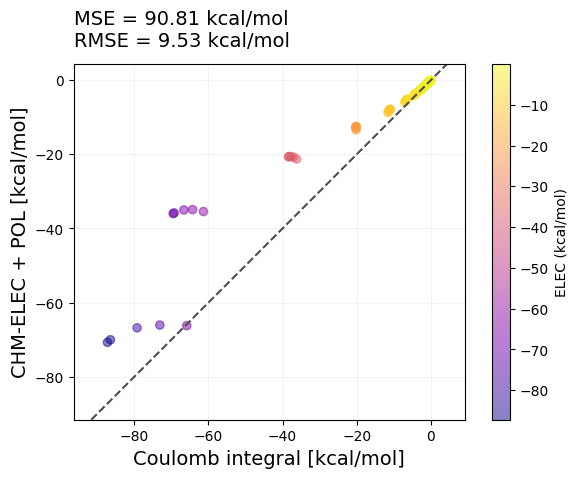

In [50]:
plot_energy_MSE(pol_3d, "ECOL", "ELECpol", 
                elec="ECOL", CMAP="plasma",
               xlabel="Coulomb integral [kcal/mol]",
               ylabel="CHM-ELEC + POL [kcal/mol]")
plt.savefig("chm_pol_vs_ci.pdf", bbox_inches="tight")

In [51]:
pol_3d

,KEYS,RS,TS,ELST,EXCH,IND,EXIND,DISP,EXDISP,ETOT,KEY,POL,ECOL,TOTAL,ELEC,VDW,ELECpol,MSE
0,1-1,0.75,180.0,-62.373121,4.056921e+02,-318.197366,2.515914e+02,-35.614933,-4.037036e-01,240.694452,1-1,-25.290578,-65.850672,56030.75158,-40.92751,11137.70216,-66.218088,0.134994
1,2-1,1.00,180.0,-61.080007,1.852532e+02,-111.370336,8.627128e+01,-20.122589,3.723402e+00,82.674903,2-1,-12.299920,-61.354694,1462.25695,-23.12944,477.46500,-35.429360,672.122942
2,3-1,1.25,180.0,-36.211838,7.964523e+01,-39.555195,2.925575e+01,-11.147753,2.685490e+00,24.671678,3-1,-7.050889,-36.208831,102.95921,-14.21051,55.36028,-21.261399,223.425715
3,4-1,1.50,180.0,-20.247849,3.307793e+01,-14.405995,9.790059e+00,-6.174418,1.462394e+00,3.502116,4-1,-4.114389,-20.171970,16.56052,-9.28255,10.23080,-13.396939,45.901050
4,5-1,1.75,180.0,-11.790530,1.349713e+01,-5.513265,3.288282e+00,-3.447615,7.158500e-01,-3.250147,5-1,-2.385451,-11.571804,15.50393,-6.35957,2.08525,-8.745021,7.990700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,12-5,3.50,90.0,-0.913704,2.024254e-02,-0.046512,2.525937e-03,-0.113131,2.312804e-03,-1.048266,12-5,-0.112443,-0.842129,15.73112,-0.67369,-0.08670,-0.786133,0.003136
76,13-5,4.25,90.0,-0.473149,1.119777e-03,-0.014520,1.380030e-04,-0.038197,1.642618e-04,-0.524445,13-5,-0.052291,-0.434121,15.57741,-0.34913,-0.03643,-0.401421,0.001069
77,14-5,5.00,90.0,-0.270115,5.359255e-05,-0.005766,9.085400e-06,-0.015719,1.147403e-05,-0.291525,14-5,-0.027987,-0.247050,15.52504,-0.19772,-0.01640,-0.225707,0.000456
78,15-5,7.00,90.0,-0.081262,-5.079888e-07,-0.000868,5.742869e-07,-0.002505,1.499236e-07,-0.084635,15-5,-0.007716,-0.074086,15.57107,-0.05817,-0.00283,-0.065886,0.000067
